<h2> Installing the Packages </h2>

In [ ]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
!pip3 install open_clip_torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 4.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-b5qfs5pw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-b5qfs5pw
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cur

In [ ]:
import math
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, InterpolationMode
import clip
from open_clip import create_model_from_pretrained


import cv2
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
clipmodel, preprocess = clip.load("ViT-B/16", device=device) #you can select Vit model for Clip
clip_inres = clipmodel.visual.input_resolution
clip_ksize = clipmodel.visual.conv1.kernel_size

print("[clip resolution]:", clip_inres)
print("[clip kernel size]:", clip_ksize)

100%|████████████████████████████████████████| 335M/335M [00:01<00:00, 197MiB/s]


[clip resolution]: 224
[clip kernel size]: (16, 16)


In [ ]:
#!unzip /pathto/images_folder # Path to you Images folder in jpeg and png format

Archive:  /content/allimages.zip
   creating: allimages/
  inflating: allimages/gzl72.jpg     
  inflating: __MACOSX/allimages/._gzl72.jpg  
  inflating: allimages/Ngl062.jpg    
  inflating: __MACOSX/allimages/._Ngl062.jpg  
  inflating: allimages/Ngl076.jpg    
  inflating: __MACOSX/allimages/._Ngl076.jpg  
  inflating: allimages/gzl66.jpg     
  inflating: __MACOSX/allimages/._gzl66.jpg  
  inflating: allimages/Nal033.jpg    
  inflating: __MACOSX/allimages/._Nal033.jpg  
  inflating: allimages/Nll004.jpg    
  inflating: __MACOSX/allimages/._Nll004.jpg  
  inflating: allimages/AAAIMD305.bmp  
  inflating: __MACOSX/allimages/._AAAIMD305.bmp  
  inflating: allimages/Nll038.jpg    
  inflating: __MACOSX/allimages/._Nll038.jpg  
  inflating: allimages/AAAIMD339.bmp  
  inflating: __MACOSX/allimages/._AAAIMD339.bmp  
  inflating: allimages/Ngl089.jpg    
  inflating: __MACOSX/allimages/._Ngl089.jpg  
  inflating: allimages/Acl261.jpg    
  inflating: __MACOSX/allimages/._Acl261.jpg  
  

<h2>Constrcutor class to load the Images Folder </h2>

In [ ]:
import random
from torchvision import transforms
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import glob
import math
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, InterpolationMode
import clip
from open_clip import create_model_from_pretrained


class ImageTitleDataset(Dataset):
    def __init__(self, image_folder, descriptions, augment=True, num_augmentations=3):
        self.image_folder = image_folder
        self.descriptions = descriptions
        self.image_paths = sorted(glob.glob(os.path.join(image_folder, '*')))
        self.titles = descriptions
        self.augment = augment
        self.num_augmentations = num_augmentations  # Number of augmentations per image-title pair

        # Define transformations for image augmentation
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        self.preprocess = transforms.Compose([
            # transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

        print(f'Original number of images: {len(self.image_paths)}')
        print(f'Original number of descriptions: {len(self.titles)}')

    def __len__(self):
        # Multiply the original dataset size by the number of augmentations
        return len(self.image_paths) * (self.num_augmentations if self.augment else 1)

    def augment_text(self, text):
        # Split the text into columns (assuming CSV format)
        columns = text.split(',')
        # Example augmentation: Shuffle the order of columns
        random.shuffle(columns)
        return ','.join(columns)  # Join the columns back into a string

    def __getitem__(self, idx):
        # Determine the original index and augmentation index
        original_idx = idx // self.num_augmentations
        aug_idx = idx % self.num_augmentations

        # Image processing
        image = Image.open(self.image_paths[original_idx])
        if self.augment:
            image = self.transform(image)  # Apply image augmentations
        else:
            image = self.preprocess(image)

        # Text processing
        title = self.titles[original_idx]
        if self.augment:
            title = self.augment_text(title)  # Apply text augmentation

        # Tokenize the augmented title
        title_tokenized = clip.tokenize([title])[0].to(device)

        return image.to(device), title_tokenized.to(device), title  # Return the augmented title for inspection

# Example usage:
# image_folder = '/content/allimages'
# description_file = '/content/DESCRIPTION3.csv' #path to the metadata CSV


# Load descriptions from the CSV file
with open(description_file, 'r') as file:
    lines = file.readlines()
    descriptions = [line.strip() for line in lines[1:]]  # Skip header line

# Create the dataset with augmentation enabled and with multiple augmentations

#Assign num_augmentations

num_augmentations = 3  # Adjust this value as needed
 # Number of augmentations per image-title pair
dataset = ImageTitleDataset(image_folder, descriptions, augment=True, num_augmentations=num_augmentations)

# Check the new number of images and titles
num_images = len(dataset)

print(f"Number of images after augmentation: {num_images}")
print(f"Total number of descriptions after augmentation: {num_images}")

# Split the dataset into 80% training and 20% testing
train_size = int(0.75* num_images)
test_size = num_images - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Print sizes of the train and test datasets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# Optionally, inspect some samples from the training set
for i in range(10):  # Adjust the range to inspect more or fewer samples
    image, title_tokenized, original_augmented_title = train_dataset[i]
    print(f"Training Sample {i+1} - Augmented Title: {original_augmented_title}")  # Print the original augmented title
    print(f"Training Sample {i+1} - Augmented Image Shape: {image.shape}")

# Optionally, inspect some samples from the testing set
for i in range(10):  # Adjust the range to inspect more or fewer samples
    image, title_tokenized, original_augmented_title = test_dataset[i]
    print(f"Testing Sample {i+1} - Augmented Title: {original_augmented_title}")  # Print the original augmented title
    print(f"Testing Sample {i+1} - Augmented Image Shape: {image.shape}")


Original number of images: 1619
Original number of descriptions: 1619
Number of images after augmentation: 4857
Total number of descriptions after augmentation: 4857
Number of training samples: 3642
Number of testing samples: 1215
Training Sample 1 - Augmented Title: absent regression structures,missing color,missing asymmetry,absent vascular structures,absent streaks,absent pigmentation,regular dots and globules,absent blue whitish veil,clark nevus,typical pigment network
Training Sample 1 - Augmented Image Shape: torch.Size([3, 224, 224])
Training Sample 2 - Augmented Title: typical pigment network,regular dots and globules,regular streaks,missing asymmetry,absent pigmentation,absent vascular structures,absent blue whitish veil,clark nevus,absent regression structures,missing color
Training Sample 2 - Augmented Image Shape: torch.Size([3, 224, 224])
Training Sample 3 - Augmented Title: irregular streaks,missing color,missing asymmetry,absent pigmentation,melanoma,irregular dots and g

In [ ]:
# import torch
# from torch.utils.data import DataLoader
# from sklearn.metrics import accuracy_score, f1_score
# import torch.nn.functional as F
# import numpy as np
# from torch.utils.data import Dataset, DataLoader, random_split
# import torch.nn as nn
# import torch.optim as optim

# # Create dataloaders for training and testing
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/16", device=device, jit=False)
# clip.model.convert_weights(model)

# loss_img = nn.CrossEntropyLoss()
# loss_txt = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.2)

# for epoch in range(25):
#     model.train()
#     total_correct = 0
#     total_images = 0

#     for batch in train_dataloader:
#         optimizer.zero_grad()

#         images, texts, _  = batch

#         logits_per_image, logits_per_text = model(images, texts)
#         logits_per_image = logits_per_image.float()
#         logits_per_text = logits_per_text.float()

#         ground_truth = torch.arange(images.size(0), dtype=torch.int64).to(device)

#         total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
#         total_loss.backward()

#         optimizer.step()

#         _, predicted = torch.max(logits_per_image, 1)
#         correct_predictions = (predicted == ground_truth).sum().item()
#         total_correct += correct_predictions
#         total_images += ground_truth.size(0)

#     epoch_accuracy = total_correct / total_images
#     print(f"Epoch {epoch + 1}, Training Accuracy: {epoch_accuracy * 100:.2f}%, Loss: {total_loss.item()}")

#     # Evaluate on the test dataset
#     model.eval()
#     test_correct = 0
#     test_images = 0

#     with torch.no_grad():
#         for batch in test_dataloader:
#             images, texts, _ = batch
#             logits_per_image, logits_per_text = model(images, texts)
#             logits_per_image = logits_per_image.float()

#             ground_truth = torch.arange(images.size(0), dtype=torch.int64).to(device)
#             _, predicted = torch.max(logits_per_image, 1)
#             correct_predictions = (predicted == ground_truth).sum().item()
#             test_correct += correct_predictions
#             test_images += ground_truth.size(0)

#     test_accuracy = test_correct / test_images
#     print(f"Epoch {epoch + 1}, Test Accuracy: {test_accuracy * 100:.2f}%")

# model_save_path = "/content/trained_modelB16.pth"
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")


In [ ]:
# import torch
# from torch.utils.data import DataLoader
# from sklearn.metrics import accuracy_score, f1_score
# import torch.nn.functional as F
# import numpy as np
# from torch.utils.data import Dataset, DataLoader, random_split
# import torch.nn as nn
# import torch.optim as optim
# import matplotlib.pyplot as plt

# # Create dataloaders for training and testing
# train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# device = "cuda:0" if torch.cuda.is_available() else "cpu"
# model, preprocess = clip.load("ViT-B/16", device=device, jit=False)
# clip.model.convert_weights(model)

# loss_img = nn.CrossEntropyLoss()
# loss_txt = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.2)

# # Lists to store accuracy and loss for each epoch
# train_accuracies = []
# train_losses = []

# for epoch in range(30):
#     model.train()
#     total_correct = 0
#     total_images = 0
#     epoch_loss = 0

#     for batch in train_dataloader:
#         optimizer.zero_grad()

#         images, texts, _  = batch

#         logits_per_image, logits_per_text = model(images, texts)
#         logits_per_image = logits_per_image.float()
#         logits_per_text = logits_per_text.float()

#         ground_truth = torch.arange(images.size(0), dtype=torch.int64).to(device)

#         total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
#         total_loss.backward()

#         optimizer.step()

#         _, predicted = torch.max(logits_per_image, 1)
#         correct_predictions = (predicted == ground_truth).sum().item()
#         total_correct += correct_predictions
#         total_images += ground_truth.size(0)
#         epoch_loss += total_loss.item()

#     epoch_accuracy = total_correct / total_images
#     epoch_loss /= len(train_dataloader)  # Average loss per batch

#     # Store the accuracy and loss
#     train_accuracies.append(epoch_accuracy)
#     train_losses.append(epoch_loss)

#     print(f"Epoch {epoch + 1}, Training Accuracy: {epoch_accuracy * 100:.2f}%, Loss: {epoch_loss:.4f}")

#     # Evaluate on the test dataset
#     model.eval()
#     test_correct = 0
#     test_images = 0

#     with torch.no_grad():
#         for batch in test_dataloader:
#             images, texts, _ = batch
#             logits_per_image, logits_per_text = model(images, texts)
#             logits_per_image = logits_per_image.float()

#             ground_truth = torch.arange(images.size(0), dtype=torch.int64).to(device)
#             _, predicted = torch.max(logits_per_image, 1)
#             correct_predictions = (predicted == ground_truth).sum().item()
#             test_correct += correct_predictions
#             test_images += ground_truth.size(0)

#     test_accuracy = test_correct / test_images
#     print(f"Epoch {epoch + 1}, Test Accuracy: {test_accuracy * 100:.2f}%")

# model_save_path = "/content/trainedmodel_B16_1.pth"
# torch.save(model.state_dict(), model_save_path)
# print(f"Model saved to {model_save_path}")


In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingLR

# Create dataloaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/16", device=device, jit=False)
clip.model.convert_weights(model)

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5, betas=(0.9, 0.98), eps=1e-6, weight_decay=0.2)

# Define scheduler
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)



# Lists to store accuracy, loss, and other metrics for each epoch
train_accuracies = []
train_losses = []
train_precisions = []
train_recalls = []
train_f1_scores = []
train_sensitivities = []
train_specificities = []

test_accuracies = []
test_precisions = []
test_recalls = []
test_f1_scores = []
test_sensitivities = []
test_specificities = []

for epoch in range(50):
    model.train()
    total_correct = 0
    total_images = 0
    epoch_loss = 0

    all_train_ground_truths = []
    all_train_predictions = []



    for batch in train_dataloader:
        optimizer.zero_grad()

        images, texts, _ = batch

        logits_per_image, logits_per_text = model(images, texts)
        logits_per_image = logits_per_image.float()
        logits_per_text = logits_per_text.float()

        ground_truth = torch.arange(images.size(0), dtype=torch.int64).to(device)

        total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
        total_loss.backward()

        optimizer.step()
        # scheduler.step()  # Step the learning rate scheduler


        _, predicted = torch.max(logits_per_image, 1)
        correct_predictions = (predicted == ground_truth).sum().item()
        total_correct += correct_predictions
        total_images += ground_truth.size(0)
        epoch_loss += total_loss.item()

        all_train_ground_truths.extend(ground_truth.cpu().numpy())
        all_train_predictions.extend(predicted.cpu().numpy())

    epoch_accuracy = total_correct / total_images
    epoch_loss /= len(train_dataloader)  # Average loss per batch

    # Calculate precision, recall, f1 score for training data
    train_precision = precision_score(all_train_ground_truths, all_train_predictions, average='macro')
    train_recall = recall_score(all_train_ground_truths, all_train_predictions, average='macro')
    train_f1 = f1_score(all_train_ground_truths, all_train_predictions, average='macro')

    # Calculate sensitivity (recall for each class) and specificity (average across all classes)
    confusion = confusion_matrix(all_train_ground_truths, all_train_predictions)
    true_positives = np.diag(confusion)
    false_positives = confusion.sum(axis=0) - true_positives
    false_negatives = confusion.sum(axis=1) - true_positives
    true_negatives = confusion.sum() - (false_positives + false_negatives + true_positives)

    train_sensitivity = np.mean(true_positives / (true_positives + false_negatives))
    train_specificity = np.mean(true_negatives / (true_negatives + false_positives))

    # Store metrics for training data
    train_accuracies.append(epoch_accuracy)
    train_losses.append(epoch_loss)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1)
    train_sensitivities.append(train_sensitivity)
    train_specificities.append(train_specificity)

    print(f"Epoch {epoch + 1}, Training Accuracy: {epoch_accuracy * 100:.2f}%, Loss: {epoch_loss:.4f}")
    print(f"Training Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1 Score: {train_f1:.4f}")
    print(f"Training Sensitivity: {train_sensitivity:.4f}, Specificity: {train_specificity:.4f}")

    # Evaluate on the test dataset
    model.eval()
    test_correct = 0
    test_images = 0
    all_test_ground_truths = []
    all_test_predictions = []

    with torch.no_grad():
        for batch in test_dataloader:
            images, texts, _ = batch
            logits_per_image, logits_per_text = model(images, texts)
            logits_per_image = logits_per_image.float()

            ground_truth = torch.arange(images.size(0), dtype=torch.int64).to(device)
            _, predicted = torch.max(logits_per_image, 1)
            correct_predictions = (predicted == ground_truth).sum().item()

            all_test_ground_truths.extend(ground_truth.cpu().numpy())
            all_test_predictions.extend(predicted.cpu().numpy())

            test_correct += correct_predictions
            test_images += ground_truth.size(0)

    test_accuracy = test_correct / test_images
    test_accuracies.append(test_accuracy)

    # Calculate precision, recall, f1 score for test data
    test_precision = precision_score(all_test_ground_truths, all_test_predictions, average='macro')
    test_recall = recall_score(all_test_ground_truths, all_test_predictions, average='macro')
    test_f1 = f1_score(all_test_ground_truths, all_test_predictions, average='macro')

    # Calculate sensitivity (recall for each class) and specificity (average across all classes) for test data
    confusion = confusion_matrix(all_test_ground_truths, all_test_predictions)
    true_positives = np.diag(confusion)
    false_positives = confusion.sum(axis=0) - true_positives
    false_negatives = confusion.sum(axis=1) - true_positives
    true_negatives = confusion.sum() - (false_positives + false_negatives + true_positives)

    test_sensitivity = np.mean(true_positives / (true_positives + false_negatives))
    test_specificity = np.mean(true_negatives / (true_negatives + false_positives))

    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_f1_scores.append(test_f1)
    test_sensitivities.append(test_sensitivity)
    test_specificities.append(test_specificity)

    print(f"Epoch {epoch + 1}, Test Accuracy: {test_accuracy * 100:.2f}%")
    print(f"Test Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1 Score: {test_f1:.4f}")
    print(f"Test Sensitivity: {test_sensitivity:.4f}, Specificity: {test_specificity:.4f}")

# Save the model
model_save_path = "/content/trainedmodel_B16_64_V2.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")



Epoch 1, Training Accuracy: 2.28%, Loss: 4.1255
Training Precision: 0.0229, Recall: 0.0228, F1 Score: 0.0205
Training Sensitivity: 0.0228, Specificity: 0.9845


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, Test Accuracy: 4.61%
Test Precision: 0.0540, Recall: 0.0461, F1 Score: 0.0444
Test Sensitivity: 0.0461, Specificity: 0.9849
Epoch 2, Training Accuracy: 4.53%, Loss: 3.8047
Training Precision: 0.0448, Recall: 0.0454, F1 Score: 0.0433
Training Sensitivity: 0.0454, Specificity: 0.9848


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2, Test Accuracy: 6.34%
Test Precision: 0.0785, Recall: 0.0633, F1 Score: 0.0613
Test Sensitivity: 0.0633, Specificity: 0.9851
Epoch 3, Training Accuracy: 7.36%, Loss: 3.6099
Training Precision: 0.0785, Recall: 0.0736, F1 Score: 0.0733
Training Sensitivity: 0.0736, Specificity: 0.9853
Epoch 3, Test Accuracy: 6.83%
Test Precision: 0.0653, Recall: 0.0683, F1 Score: 0.0641
Test Sensitivity: 0.0683, Specificity: 0.9852
Epoch 4, Training Accuracy: 9.42%, Loss: 3.4743
Training Precision: 0.0973, Recall: 0.0941, F1 Score: 0.0937
Training Sensitivity: 0.0941, Specificity: 0.9856
Epoch 4, Test Accuracy: 9.79%
Test Precision: 0.1077, Recall: 0.0979, F1 Score: 0.0977
Test Sensitivity: 0.0979, Specificity: 0.9857
Epoch 5, Training Accuracy: 12.03%, Loss: 3.3168
Training Precision: 0.1249, Recall: 0.1203, F1 Score: 0.1207
Training Sensitivity: 0.1203, Specificity: 0.9860
Epoch 5, Test Accuracy: 12.10%
Test Precision: 0.1196, Recall: 0.1209, F1 Score: 0.1164
Test Sensitivity: 0.1209, Specifici

In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import torch.nn as nn
import torch.optim as optim
import optuna

# Define your objective function for Optuna
def objective(trial):

    # Hyperparameters to tune
    batch_size = trial.suggest_int('batch_size', 64, 128, step=16)
    learning_rate = trial.suggest_loguniform('lr', 1e-7, 1e-3)
    weight_decay = trial.suggest_loguniform('weight_decay', 0.01, 0.4)
    T_max = trial.suggest_int('T_max', 10, 50)

    # Create dataloaders for training and testing
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-B/16", device=device, jit=False)
    clip.model.convert_weights(model)

    loss_img = nn.CrossEntropyLoss()
    loss_txt = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-6, weight_decay=weight_decay)

    # Define scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

    for epoch in range(50):
        model.train()
        total_correct = 0
        total_images = 0
        epoch_loss = 0

        all_train_ground_truths = []
        all_train_predictions = []

        for batch in train_dataloader:
            optimizer.zero_grad()

            images, texts, _ = batch

            logits_per_image, logits_per_text = model(images, texts)
            logits_per_image = logits_per_image.float()
            logits_per_text = logits_per_text.float()

            ground_truth = torch.arange(images.size(0), dtype=torch.int64).to(device)

            total_loss = (loss_img(logits_per_image, ground_truth) + loss_txt(logits_per_text, ground_truth)) / 2
            total_loss.backward()

            optimizer.step()
            scheduler.step()  # Step the learning rate scheduler

            _, predicted = torch.max(logits_per_image, 1)
            correct_predictions = (predicted == ground_truth).sum().item()
            total_correct += correct_predictions
            total_images += ground_truth.size(0)
            epoch_loss += total_loss.item()

            all_train_ground_truths.extend(ground_truth.cpu().numpy())
            all_train_predictions.extend(predicted.cpu().numpy())

        epoch_accuracy = total_correct / total_images
        epoch_loss /= len(train_dataloader)  # Average loss per batch

    return epoch_accuracy  # Optuna will maximize this value

# Set up the Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  # Number of trials can be adjusted

# Get the best hyperparameters
best_params = study.best_params
print("Best hyperparameters found:")
print(best_params)

# Once you've found the best hyperparameters, you can train the final model with them


In [ ]:
from google.colab import files

# Download the file to your local machine
files.download('/content/trainedmodel_B16_64_new.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

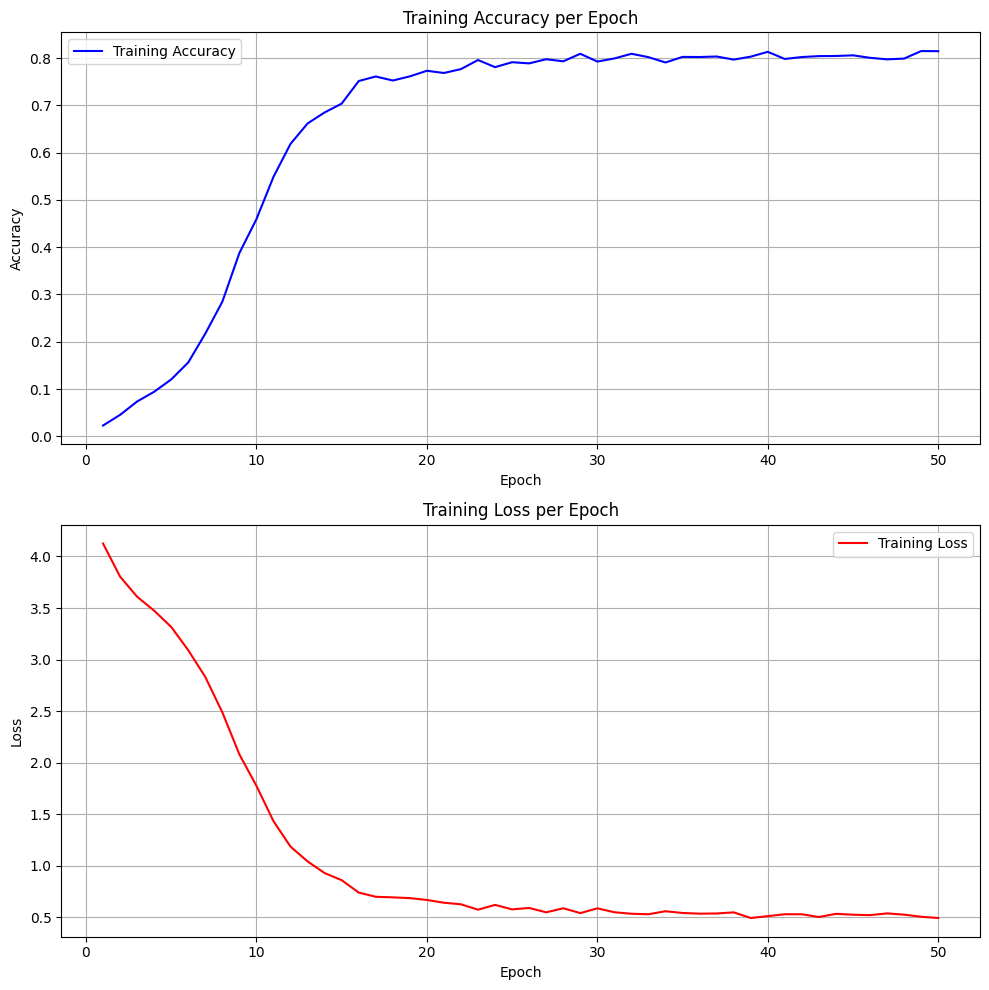

In [ ]:
# Assuming you trained for 25 epochs
epochs = range(1, len(train_accuracies) + 1)

# Create subplots: one for accuracy and one for loss
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plot Training Accuracy
axs[0].plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Training Accuracy per Epoch')
axs[0].legend()
axs[0].grid(True)

# Plot Training Loss
axs[1].plot(epochs, train_losses, label='Training Loss', color='red')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Training Loss per Epoch')
axs[1].legend()
axs[1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()



Number of test samples: 1215
Accuracy: 84.12%
F1-Score: 0.8414
Average Loss: 0.3480
Average CLIP Score: 0.9548


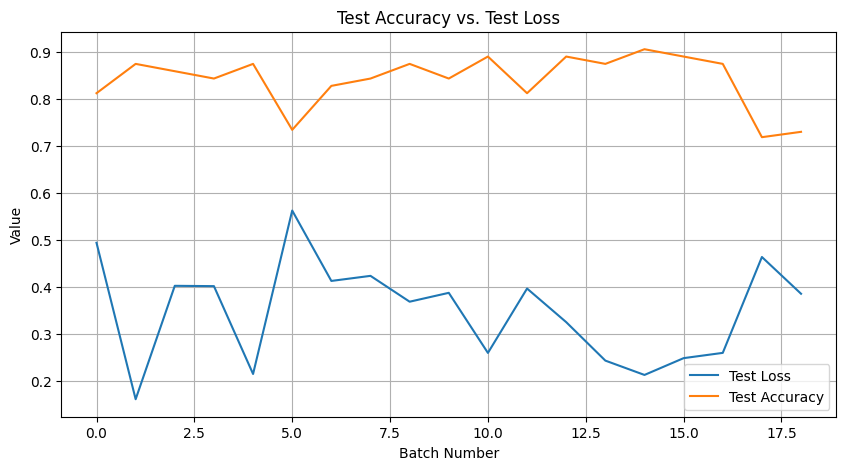

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score

# Create DataLoader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# Print the number of test samples
print(f"Number of test samples: {len(test_dataset)}")

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load the trained model weights
model.load_state_dict(torch.load("/content/trainedmodel_B16_64_V2.pth", map_location=device))

# Set the model to evaluation mode
model.eval()

all_preds = []
all_targets = []
total_loss = 0
total_clip_score = 0
num_samples = 0
batch_accuracies = []
batch_losses = []

with torch.no_grad():
    for batch in test_dataloader:
        images, titles, _ = batch  # Unpack the batch, ignoring the original text

        # Move images and titles to the correct device
        images = images.to(device)
        titles = titles.to(device)

        # Forward pass through the model (assuming it has the same interface as CLIP)
        logits_per_image, logits_per_text = model(images, titles)

        # Calculate similarity scores between images and texts
        logits_per_image = logits_per_image.float()  # Ensure the output is in float
        logits_per_text = logits_per_text.float()

        # Normalize the features
        image_features = logits_per_image / logits_per_image.norm(dim=-1, keepdim=True)
        text_features = logits_per_text / logits_per_text.norm(dim=-1, keepdim=True)

        # Calculate the CLIP score (cosine similarity) for each image-text pair
        clip_scores = (image_features * text_features).sum(dim=-1)  # Element-wise multiplication and summation
        total_clip_score += clip_scores.sum().item()
        num_samples += len(images)

        # Create ground truth labels (0 to batch_size-1)
        ground_truth = torch.arange(len(images)).to(device)

        # Calculate loss
        loss = F.cross_entropy(logits_per_image, ground_truth)
        total_loss += loss.item()

        # Predictions: get the index with the highest similarity score
        preds = logits_per_image.argmax(dim=-1)

        # Collect predictions and targets for accuracy and F1-score calculation
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(ground_truth.cpu().numpy())

        batch_accuracy = accuracy_score(ground_truth.cpu().numpy(), preds.cpu().numpy())
        batch_accuracies.append(batch_accuracy)
        batch_losses.append(loss.item())

# Calculate metrics
accuracy = accuracy_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds, average='weighted')
average_loss = total_loss / len(test_dataloader)
average_clip_score = total_clip_score / num_samples

# Print the results
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1-Score: {f1:.4f}")
print(f"Average Loss: {average_loss:.4f}")
print(f"Average CLIP Score: {average_clip_score:.4f}")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(batch_losses, label='Test Loss')
plt.plot(batch_accuracies, label='Test Accuracy')
plt.xlabel('Batch Number')
plt.ylabel('Value')
plt.title('Test Accuracy vs. Test Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# import torch
# from torch.utils.data import DataLoader
# from sklearn.metrics import accuracy_score, f1_score
# import torch.nn.functional as F


# # Create DataLoader for the test dataset
# test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# # Print the number of test samples
# print(f"Number of test samples: {len(test_dataset)}")

# device = "cuda:0" if torch.cuda.is_available() else "cpu"

# # Load the pretrained CLIP model
# model, preprocess = clip.load("ViT-B/16", device=device, jit=False)
# model.eval()

# all_preds = []
# all_targets = []
# total_loss = 0
# with torch.no_grad():
#     for batch in test_dataloader:
#         images, titles, _ = batch  # Unpack the batch, ignoring the original text

#         # Move images and titles to the correct device
#         images = images.to(device)
#         titles = titles.to(device)

#         # Encode images and text
#         image_embeddings = model.encode_image(images)
#         image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)

#         text_embeddings = model.encode_text(titles)
#         text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

#         # Calculate similarity scores between images and texts
#         logits_per_image = image_embeddings @ text_embeddings.T

#         # Create ground truth labels (0 to batch_size-1)
#         ground_truth = torch.arange(len(images)).to(device)

#         # Calculate loss
#         loss = F.cross_entropy(logits_per_image, ground_truth)
#         total_loss += loss.item()

#         # Predictions: get the index with the highest similarity score
#         preds = logits_per_image.argmax(dim=-1)

#         # Collect predictions and targets for accuracy and F1-score calculation
#         all_preds.extend(preds.cpu().numpy())
#         all_targets.extend(ground_truth.cpu().numpy())

# # Calculate metrics
# accuracy = accuracy_score(all_targets, all_preds)
# f1 = f1_score(all_targets, all_preds, average='weighted')
# average_loss = total_loss / len(test_dataloader)

# # Print the results
# print(f"Accuracy: {accuracy * 100:.2f}%")
# print(f"F1-Score: {f1:.4f}")
# print(f"Average Loss: {average_loss:.4f}")


Number of test samples: 1215
Accuracy: 2.96%
F1-Score: 0.0253
Average Loss: 3.4649


Number of test samples: 1215
Accuracy: 1.56%
F1-Score: 0.0074
Average Loss: 4.1585
Average CLIP Score: 0.1060


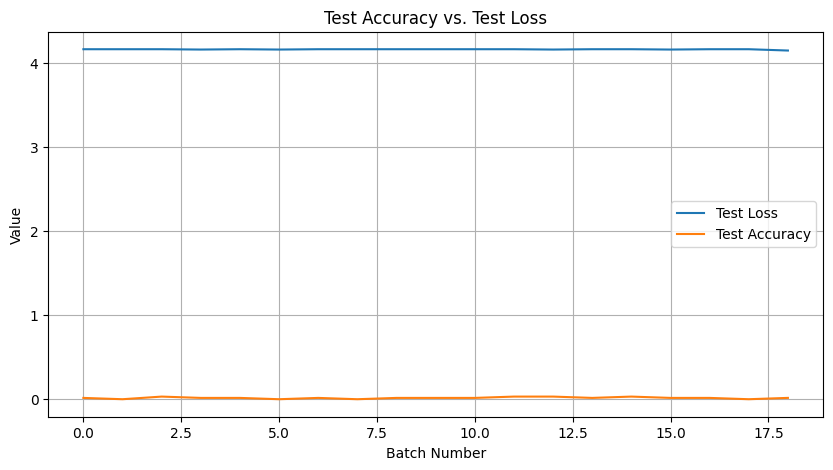

In [ ]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score
import torch.nn.functional as F


# Create DataLoader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# Print the number of test samples
print(f"Number of test samples: {len(test_dataset)}")

device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Load the pretrained CLIP model
model, preprocess = clip.load("ViT-B/16", device=device, jit=False)
model.eval()

all_preds = []
all_targets = []
total_loss = 0
total_clip_score = 0
num_samples = 0
batch_accuracies = []
batch_losses = []
with torch.no_grad():
    for batch in test_dataloader:
        images, titles, _ = batch
        images = images.to(device)
        titles = titles.to(device)

        image_embeddings = model.encode_image(images)
        image_embeddings /= image_embeddings.norm(dim=-1, keepdim=True)

        text_embeddings = model.encode_text(titles)
        text_embeddings /= text_embeddings.norm(dim=-1, keepdim=True)

        logits_per_image = image_embeddings @ text_embeddings.T

        clip_scores = (image_features * text_features).sum(dim=-1)
        total_clip_score += clip_scores.sum().item()
        num_samples += len(images)

        ground_truth = torch.arange(len(images)).to(device)

        loss = F.cross_entropy(logits_per_image, ground_truth)
        total_loss += loss.item()

        preds = logits_per_image.argmax(dim=-1)

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(ground_truth.cpu().numpy())

        batch_accuracy = accuracy_score(ground_truth.cpu().numpy(), preds.cpu().numpy())
        batch_accuracies.append(batch_accuracy)
        batch_losses.append(loss.item())

accuracy = accuracy_score(all_targets, all_preds)
f1 = f1_score(all_targets, all_preds, average='weighted')
average_loss = total_loss / len(test_dataloader)
average_clip_score = total_clip_score / num_samples
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"F1-Score: {f1:.4f}")
print(f"Average Loss: {average_loss:.4f}")
print(f"Average CLIP Score: {average_clip_score:.4f}")

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(batch_losses, label='Test Loss')
plt.plot(batch_accuracies, label='Test Accuracy')
plt.xlabel('Batch Number')
plt.ylabel('Value')
plt.title('Test Accuracy vs. Test Loss')
plt.legend()
plt.grid(True)
plt.show()